In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%ls -ltrh /Users/laurentperrinet/quantic/grants/Polychronies/RSG-spikepatterns/Data/

In [ ]:
i_session = 0
monkey = 'G'
from pathlib import Path
path = Path.home()/'quantic'/'grants'/'polychronies'/'RSG-spikepatterns'/'Data'/f'{monkey}_Ready-Set_bin1ms_alignedReady_session={i_session}.npz'

dictdata = np.load(path)
data, id_neuron, id_short, t_s, t_p = dictdata['data'], dictdata['id_neuron'], dictdata['id_short'], dictdata['t_s'], dictdata['t_p']
data = data.astype(float)
data[data==255] = np.nan
N_time, N_neuron, N_trial = data.shape

N_time, N_neuron, N_trial

### computing the firing rates

In [ ]:
t_s_max = int(t_s.max())
DeltaT = 100 # number of time bins on which we average
dt = 20 # temporal distance between points on which we compute the firing rate

timepoints = np.arange(DeltaT, t_s_max+1, dt)
N_timepoint = len(timepoints)
timepoints, N_timepoint

In [ ]:
fr = np.empty((N_timepoint, N_neuron, N_trial)) * np.nan
for i_timepoint, timepoint in enumerate(timepoints):
    fr[i_timepoint, :, :] = np.nansum(data[(timepoint-DeltaT):timepoint, :, :], axis=0) / (DeltaT/1000)

In [ ]:
# for i_trial in range(N_trial):
#     print(i_trial, torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum())
#     break
# torch.isnan(torch.tensor(fr.astype(float))).sum(), torch.isnan(torch.tensor(data.astype(float))).sum()

In [ ]:
fr.shape

In [ ]:
ratio_train = 80/100
N_trial_train = int(N_trial*ratio_train)
N_trial_test = N_trial - N_trial_train
idx_trial = np.random.permutation(N_trial)
idx_trial

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(fr[:, :, 102], cmap='viridis')

### logistic regression model with NaNs

### inference model

In [ ]:
import torch
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

device = 'cpu'

In [ ]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# torch.set_default_tensor_type("torch.FloatTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size


class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, N_neuron, N_timepoint, logit0=-2., logit_wt=0.1):
        super(LogisticRegressionModel, self).__init__() 
        self.bias = torch.nn.Parameter(logit0*torch.ones(1, N_timepoint))
        self.weight = torch.nn.Parameter(logit_wt * torch.randn((N_neuron, N_timepoint)))
        # self.nl = torch.nn.Softmax(N_timepoint)
        # self.nl = torch.nn.Sigmoid()

    def forward(self, X_input):
        # X_input.shape = N_batch, N_neuron
        X_input[torch.isnan(X_input)] = 0.
        # return self.nl(X_input @ self.weight +  self.bias)
        # print(X_input.dtype, self.bias.dtype, self.weight.dtype)
        return F.softmax(torch.tensordot(X_input, self.weight, dims=1) +  self.bias, dim=1)

In [ ]:
# F.softmax?
# torch.tensor?

In [ ]:
logistic_model = LogisticRegressionModel(N_neuron, N_timepoint)
i_trial = 3
X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
outputs = logistic_model(X)
X.shape, outputs.shape

In [ ]:
X.sum(axis=1), (X.sum(axis=1)>0).shape

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(X.numpy(), cmap='viridis')

In [ ]:
N_timepoint, np.arange(N_timepoint),  np.arange(N_timepoint)[X.sum(axis=1)>0]


In [28]:
X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
X = X[time_labels, :]
outputs = logistic_model(X)
time_labels, X.shape, outputs.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 torch.Size([24, 107]),
 torch.Size([24, 56]))

In [29]:
F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs.detach().numpy(), cmap='viridis')

In [19]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(fr,
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):


    logistic_model = LogisticRegressionModel(N_neuron, N_timepoint)
    # logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for i_trial in idx_trial[range(N_trial_train)]:
            X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
            time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
            X = X[time_labels, :]
            labels = F.one_hot(torch.tensor(time_labels), num_classes=N_timepoint)*1.
            # X, labels = X.to(device), labels.to(device)
            outputs = logistic_model(X)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    return logistic_model, np.mean(losses)

logistic_model, loss = fit_data(fr, verbose=True)

Iteration: 80 - Loss: 0.12668
Iteration: 96 - Loss: 0.12657
Iteration: 112 - Loss: 0.12452
Iteration: 128 - Loss: 0.13811
Iteration: 144 - Loss: 0.12936
Iteration: 160 - Loss: 0.13012
Iteration: 176 - Loss: 0.13465
Iteration: 192 - Loss: 0.13535
Iteration: 208 - Loss: 0.13414
Iteration: 224 - Loss: 0.12981
Iteration: 240 - Loss: 0.13785
Iteration: 256 - Loss: 0.13810
Iteration: 272 - Loss: 0.13250
Iteration: 288 - Loss: 0.12909
Iteration: 304 - Loss: 0.13368
Iteration: 320 - Loss: 0.13702
Iteration: 336 - Loss: 0.13527
Iteration: 352 - Loss: 0.13082
Iteration: 368 - Loss: 0.13517
Iteration: 384 - Loss: 0.13188
Iteration: 400 - Loss: 0.12883
Iteration: 416 - Loss: 0.13324
Iteration: 432 - Loss: 0.13282
Iteration: 448 - Loss: 0.13451
Iteration: 464 - Loss: 0.13681
Iteration: 480 - Loss: 0.13620
Iteration: 496 - Loss: 0.13515
Iteration: 512 - Loss: 0.13659


In [20]:
logistic_model.weight.detach().numpy().shape, logistic_model.weight.detach().numpy().ravel().shape

((107, 56), (5992,))

In [21]:
with torch.no_grad():
    counts = np.zeros((N_timepoint, N_timepoint))
    outputs = np.zeros((N_timepoint, N_timepoint))
    for i_trial in idx_trial[range(N_trial_train, N_trial)]:
        X = torch.tensor(fr[:, :, i_trial], dtype=torch.float64)
        time_labels = np.arange(N_timepoint)[X.sum(axis=1)>0]
        counts[time_labels, :] += 1
        X = X[time_labels, :]
        output = logistic_model(X).numpy()
        outputs[time_labels, :] += output

    outputs = outputs/counts

outputs, outputs.shape, counts, outputs.sum(axis=1)

(array([[1.83777650e-001, 8.09985936e-002, 3.46885654e-002, ...,
         1.01209345e-004, 1.12798960e-003, 0.00000000e+000],
        [1.67569823e-001, 8.41999111e-002, 3.18508474e-002, ...,
         2.19852760e-003, 1.69397752e-003, 0.00000000e+000],
        [1.50796238e-001, 8.42861261e-002, 3.60966246e-002, ...,
         3.21204162e-003, 7.23313626e-004, 0.00000000e+000],
        ...,
        [3.30086091e-002, 1.09592364e-002, 4.33729693e-003, ...,
         7.89342468e-003, 1.51794097e-002, 3.26885738e-234],
        [1.75080031e-002, 1.04079780e-002, 3.44823750e-003, ...,
         7.93304593e-003, 2.52999473e-002, 3.16630147e-087],
        [1.61734712e-002, 8.16595922e-003, 1.29567121e-003, ...,
         9.67347045e-006, 3.22046001e-002, 0.00000000e+000]]),
 (56, 56),
 array([[300., 300., 300., ..., 300., 300., 300.],
        [300., 300., 300., ..., 300., 300., 300.],
        [300., 300., 300., ..., 300., 300., 300.],
        ...,
        [ 57.,  57.,  57., ...,  57.,  57.,  57.],
 

In [22]:
outputs.min(), outputs.max()

(0.0, 0.18377765031903992)

In [23]:
counts.min(), counts.max()

(31.0, 300.0)

In [24]:
torch.isnan(torch.tensor(fr[:, :, i_trial].astype(float))).sum(), 

(tensor(0),)

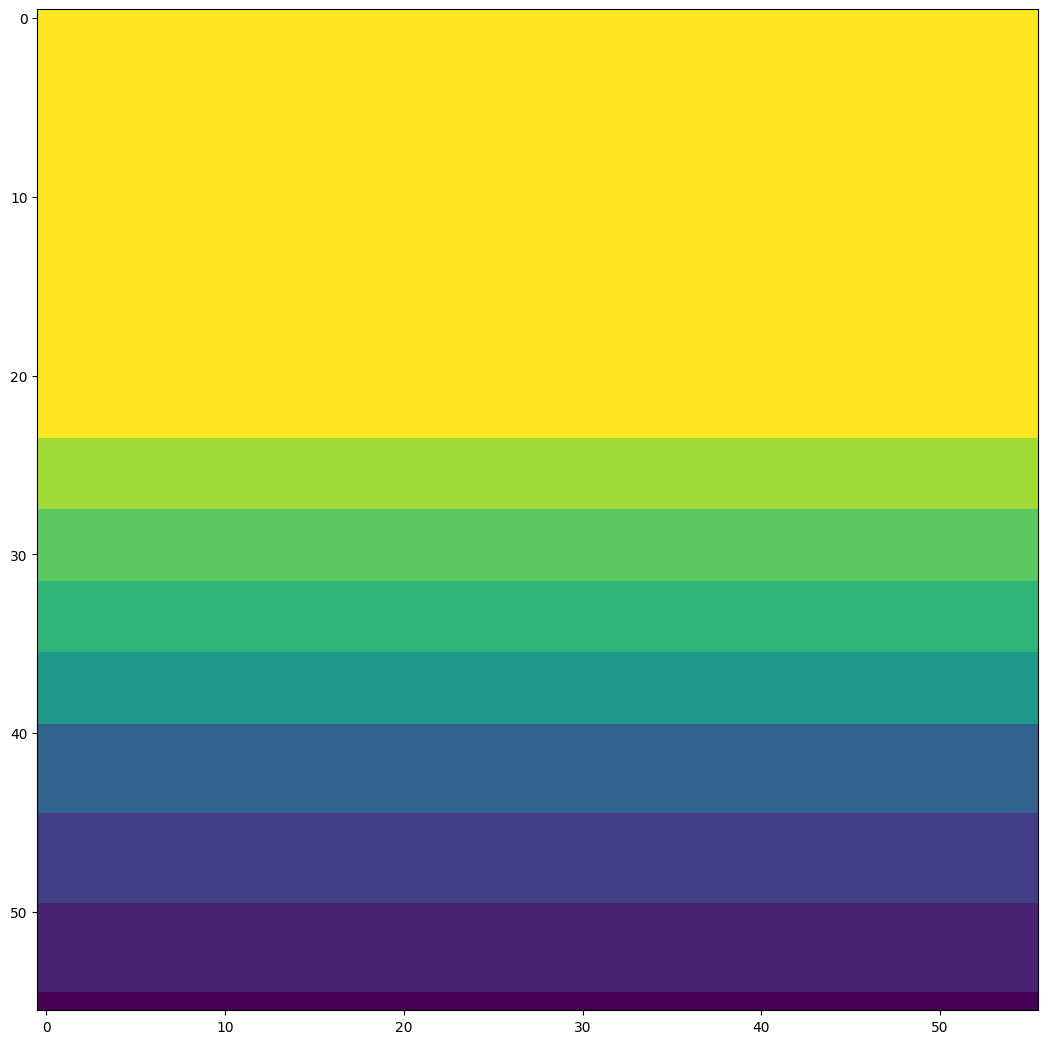

In [25]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(counts, cmap='viridis')

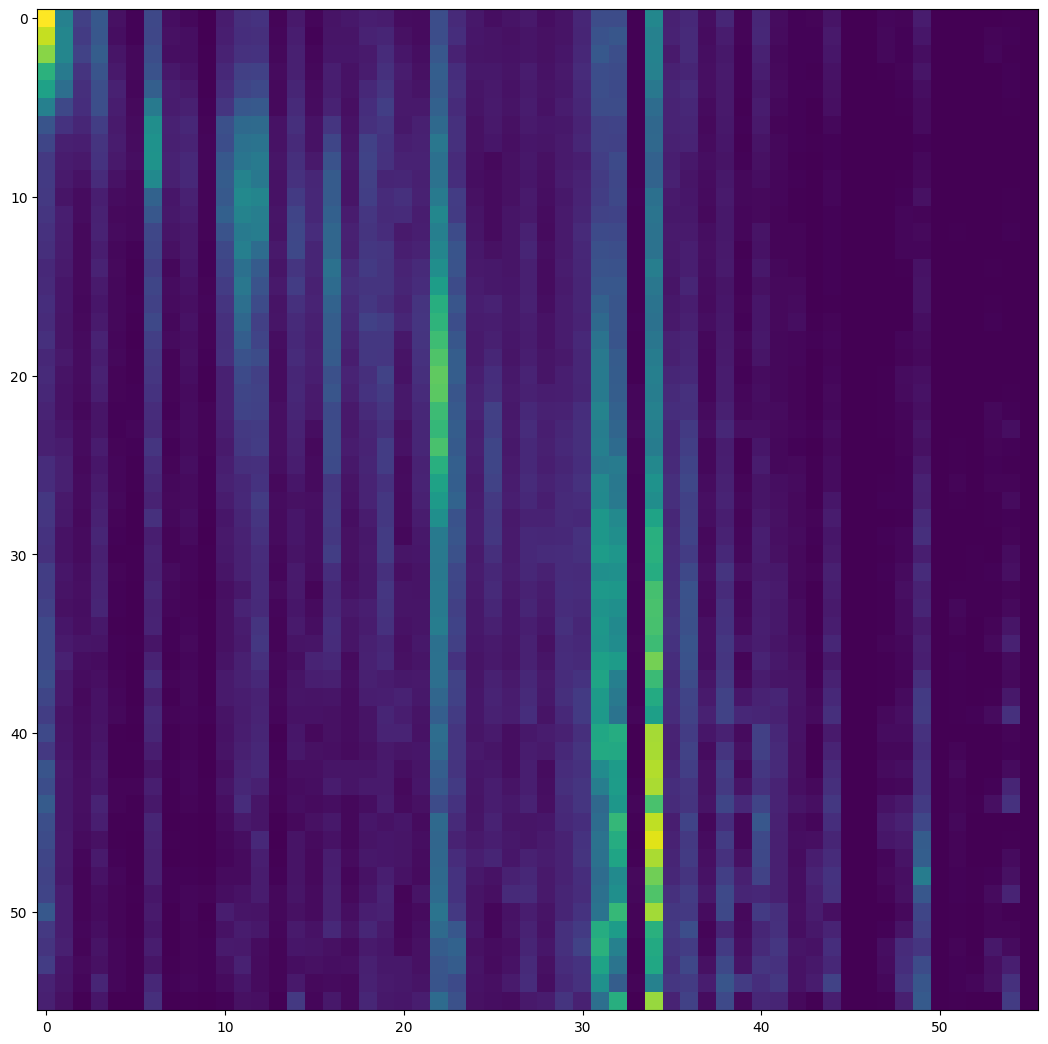

In [26]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(outputs, cmap='viridis')

In [27]:
outputs[:5, :5]

array([[0.18377765, 0.08099859, 0.03468857, 0.0505439 , 0.00819264],
       [0.16756982, 0.08419991, 0.03185085, 0.05015101, 0.00677052],
       [0.15079624, 0.08428613, 0.03609662, 0.05432921, 0.01012603],
       [0.11801813, 0.07478272, 0.02746224, 0.04803581, 0.01232994],
       [0.1049067 , 0.06624026, 0.02495339, 0.04386906, 0.01706698]])

## scan parameters

In [ ]:

N_scale = 5
for learning_rate_ in learning_rate*np.logspace(-1, 1, N_scale, base=10)
    logistic_model, loss = fit_data(fr, learning_rate=learning_rate_, verbose=False)
    print(f'learning_rate={learning_rate_}:{loss=}')